In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mglearn

from IPython.display import display

%matplotlib inline

pd.options.display.max_rows = 15

sns.set()

In [2]:
original_data = pd.read_csv('data/titanic/train.csv', index_col='PassengerId')

In [3]:
lecture_data_final = original_data.copy()

lecture_data_final['Title'] = lecture_data_final.Name.str.extract('([A-Za-z]+)\.', expand=False)
lecture_data_final['FamilySize'] = lecture_data_final.Parch + lecture_data_final.SibSp + 1
lecture_data_final['Male'] = (lecture_data_final.Sex == 'male').astype(int)
lecture_data_final['Embarked'] = lecture_data_final.Embarked.fillna('S')
lecture_data_final['Embarked'] = lecture_data_final.Embarked.apply(lambda x: ['C', 'S', 'Q'].index(x))

lecture_data_final.loc[lecture_data_final.Title == 'Mlle', 'Title'] = 'Miss'
lecture_data_final.loc[lecture_data_final.Title == 'Mme', 'Title']  = 'Mrs'
lecture_data_final.loc[lecture_data_final.Title == 'Ms', 'Title']   = 'Miss'

rare_titles = ['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Don', 'Jonkheer', 'Capt', 'Lady', 'Sir', 'Dona']
lecture_data_final.Title = lecture_data_final.Title.replace(rare_titles, 'Rare')

age_by_title = lecture_data_final.groupby('Title').Age.mean()

lecture_data_final.loc[lecture_data_final.Age.isnull() & (lecture_data_final.Title == 'Mr'), 'Age'] = age_by_title['Mr']
lecture_data_final.loc[lecture_data_final.Age.isnull() & (lecture_data_final.Title == 'Mrs'), 'Age'] = age_by_title['Mrs']
lecture_data_final.loc[lecture_data_final.Age.isnull() & (lecture_data_final.Title == 'Miss'), 'Age'] = age_by_title['Miss']
lecture_data_final.loc[lecture_data_final.Age.isnull() & (lecture_data_final.Title == 'Master'), 'Age'] = age_by_title['Master']
lecture_data_final.loc[lecture_data_final.Age.isnull() & (lecture_data_final.Title == 'Rare'), 'Age'] = age_by_title['Rare']

lecture_data_final['Title'] = lecture_data_final.Title.apply(lambda x: ['Mr', 'Mrs', 'Miss', 'Master', 'Rare'].index(x))

lecture_data_final = lecture_data_final.drop(['Sex', 'Name', 'Ticket', 'Fare', 'Parch', 'SibSp', 'Survived', 'Cabin'], axis=1)
lecture_data_final

,Pclass,Age,Embarked,Title,FamilySize,Male
PassengerId,,,,,,
1,3,22.000000,1,0,2,1
2,1,38.000000,0,1,2,0
3,3,26.000000,1,2,1,0
4,1,35.000000,1,1,2,0
5,3,35.000000,1,0,1,1
6,3,32.368090,2,0,1,1
7,1,54.000000,1,0,1,1
...,...,...,...,...,...,...
885,3,25.000000,1,0,1,1


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

lecture_model_forest = RandomForestClassifier(random_state=0, max_depth=4, n_estimators=70)

result = cross_val_score(lecture_model_forest, lecture_data_final, original_data.Survived)

print(result)
print(result.mean())

[ 0.82491582  0.84511785  0.83501684]
0.835016835017


In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[[self.key]]

In [6]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer, StandardScaler, OneHotEncoder
from sklearn.svm import LinearSVC, SVC

model_1 = Pipeline([
    ('union', FeatureUnion([
        ('age', Pipeline([
            ('select', ItemSelector('Age')),
            ('scaler', StandardScaler()),
        ])),
        ('gender', Pipeline([
            ('select', ItemSelector('Male')),
            ('encoder', OneHotEncoder()),
        ])),        
        ('family_size', Pipeline([
            ('select', ItemSelector('FamilySize')),
            ('scaler', StandardScaler())
        ])),
        ('title', Pipeline([
            ('select', ItemSelector('Title')),
            ('encoder', OneHotEncoder()),
        ])),
        ('embarked', Pipeline([
            ('select', ItemSelector('Embarked')),
            ('encoder', OneHotEncoder()),
        ])),
        ('class', Pipeline([
            ('select', ItemSelector('Pclass')),
            ('encoder', OneHotEncoder()),
        ])),
        
    ])),
    ('linear-svc', LinearSVC())
])

In [7]:
grid = {
    'linear-svc__C': [0.001, 0.01, 1, 10, 100, 1000]
}

In [8]:
from sklearn.model_selection import GridSearchCV

X = lecture_data_final
y = original_data.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

search = GridSearchCV(model_1, param_grid=grid, cv=3)
search.fit(X_train, y_train)
search.best_params_

{'linear-svc__C': 1}

In [9]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_linear-svc__C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.010876,0.007875,0.809880,0.809133,0.001,{'linear-svc__C': 0.001},4,0.798206,0.811236,0.807175,0.808989,0.824324,0.807175,0.000635,0.000176,0.010829,0.001661
1,0.011250,0.007761,0.823353,0.824109,0.01,{'linear-svc__C': 0.01},3,0.802691,0.829213,0.811659,0.829213,0.855856,0.813901,0.000456,0.000113,0.023222,0.007218
2,0.018286,0.008499,0.832335,0.835334,1,{'linear-svc__C': 1},1,0.820628,0.838202,0.816143,0.838202,0.860360,0.829596,0.000974,0.000158,0.019857,0.004057
3,0.026210,0.008352,0.832335,0.833090,10,{'linear-svc__C': 10},1,0.820628,0.838202,0.816143,0.835955,0.860360,0.825112,0.000909,0.000330,0.019857,0.005715
4,0.029233,0.008398,0.790419,0.809902,100,{'linear-svc__C': 100},5,0.789238,0.842697,0.802691,0.806742,0.779279,0.780269,0.001412,0.000554,0.009591,0.025584
5,0.029461,0.010182,0.658683,0.634630,1000,{'linear-svc__C': 1000},6,0.385650,0.386517,0.780269,0.748315,0.810811,0.769058,0.001678,0.000314,0.193681,0.175647


с C=1 имаме най-добри резултати, който все пак са по-ниски от RandomForest

In [10]:
result = cross_val_score(model_1, lecture_data_final, original_data.Survived)

print(result)
print(result.mean())

[ 0.80808081  0.83164983  0.83838384]
0.826038159371


In [11]:
model_2 = Pipeline([
    ('union', FeatureUnion([
        ('age', Pipeline([
            ('select', ItemSelector('Age')),
            ('scaler', StandardScaler()),
        ])),
        ('gender', Pipeline([
            ('select', ItemSelector('Male')),
            ('encoder', OneHotEncoder()),
        ])),        
        ('family_size', Pipeline([
            ('select', ItemSelector('FamilySize')),
            ('scaler', StandardScaler())
        ])),
        ('title', Pipeline([
            ('select', ItemSelector('Title')),
            ('encoder', OneHotEncoder()),
        ])),
        ('embarked', Pipeline([
            ('select', ItemSelector('Embarked')),
            ('encoder', OneHotEncoder()),
        ])),
        ('class', Pipeline([
            ('select', ItemSelector('Pclass')),
            ('encoder', OneHotEncoder()),
        ])),
        
    ])),
    ('svc', SVC())
])

In [12]:
grid = {
    'svc__C': [0.001, 0.01, 1, 10, 100, 1000],
    'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100]
}
search = GridSearchCV(model_2, param_grid=grid, cv=3)
search.fit(X_train, y_train)
search.best_params_

{'svc__C': 100, 'svc__gamma': 0.01}

In [13]:
res = pd.DataFrame(search.cv_results_).sort_values('rank_test_score')
res

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_svc__C,param_svc__gamma,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
25,0.019333,0.008482,0.835329,0.840572,100,0.01,"{'svc__C': 100, 'svc__gamma': 0.01}",1,0.829596,0.840449,0.829596,0.844944,0.846847,0.836323,0.000936,0.000104,0.008126,0.003521
14,0.014069,0.008352,0.827844,0.840572,1,0.1,"{'svc__C': 1, 'svc__gamma': 0.1}",2,0.807175,0.840449,0.816143,0.844944,0.860360,0.836323,0.000159,0.000018,0.023231,0.003521
31,0.084190,0.009729,0.826347,0.848058,1000,0.01,"{'svc__C': 1000, 'svc__gamma': 0.01}",3,0.825112,0.849438,0.825112,0.851685,0.828829,0.843049,0.021854,0.001294,0.001751,0.003658
20,0.016327,0.008233,0.826347,0.852549,10,0.1,"{'svc__C': 10, 'svc__gamma': 0.1}",3,0.829596,0.853933,0.829596,0.856180,0.819820,0.847534,0.000998,0.000082,0.004605,0.003663
19,0.014285,0.008301,0.824850,0.827102,10,0.01,"{'svc__C': 10, 'svc__gamma': 0.01}",5,0.802691,0.835955,0.816143,0.826966,0.855856,0.818386,0.000875,0.000158,0.022555,0.007173
30,0.021284,0.008307,0.824850,0.832339,1000,0.001,"{'svc__C': 1000, 'svc__gamma': 0.001}",5,0.807175,0.835955,0.811659,0.833708,0.855856,0.827354,0.002088,0.000155,0.021952,0.003642
24,0.013977,0.008488,0.821856,0.827855,100,0.001,"{'svc__C': 100, 'svc__gamma': 0.001}",7,0.802691,0.831461,0.816143,0.838202,0.846847,0.813901,0.000162,0.000280,0.018468,0.010243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,0.017784,0.010951,0.613772,0.613772,0.001,100,"{'svc__C': 0.001, 'svc__gamma': 100}",24,0.614350,0.613483,0.614350,0.613483,0.612613,0.614350,0.001348,0.001261,0.000818,0.000409
4,0.016121,0.009573,0.613772,0.613772,0.001,10,"{'svc__C': 0.001, 'svc__gamma': 10}",24,0.614350,0.613483,0.614350,0.613483,0.612613,0.614350,0.000341,0.000464,0.000818,0.000409


In [14]:
result = np.array([res.loc[25].split0_test_score, res.loc[25].split1_test_score, res.loc[25].split2_test_score])

print(result)
print(result.mean())

[ 0.82959641  0.82959641  0.84684685]
0.83534655732


In [15]:
original_data


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
...,...,...,...,...,...,...,...,...,...,...,...
885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S


кабината може ли да ни донесе някакви резултати?

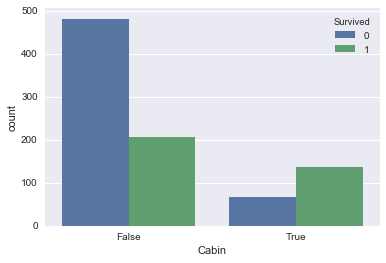

In [16]:
copy = original_data.copy()
copy['Cabin'] = ~copy.Cabin.isnull().astype(bool)

sns.countplot('Cabin', hue='Survived', data=copy);

In [17]:
data = lecture_data_final.copy()

data['Cabin'] = original_data.Cabin.isnull().astype(int)
data

,Pclass,Age,Embarked,Title,FamilySize,Male,Cabin
PassengerId,,,,,,,
1,3,22.000000,1,0,2,1,1
2,1,38.000000,0,1,2,0,0
3,3,26.000000,1,2,1,0,1
4,1,35.000000,1,1,2,0,0
5,3,35.000000,1,0,1,1,1
6,3,32.368090,2,0,1,1,1
7,1,54.000000,1,0,1,1,0
...,...,...,...,...,...,...,...
885,3,25.000000,1,0,1,1,1


In [18]:
search = GridSearchCV(RandomForestClassifier(), {'n_estimators': [10, 30, 50, 70, 100],
                              'max_depth': [2, 4, 6, 8, 10, 12, 15]})
X = data
y = original_data.Survived

search.fit(X, y)

pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(10)


,rank_test_score,mean_test_score,params
11,1,0.833895,"{'max_depth': 6, 'n_estimators': 30}"
7,2,0.831650,"{'max_depth': 4, 'n_estimators': 50}"
9,3,0.830527,"{'max_depth': 4, 'n_estimators': 100}"
13,4,0.829405,"{'max_depth': 6, 'n_estimators': 70}"
10,4,0.829405,"{'max_depth': 6, 'n_estimators': 10}"
12,4,0.829405,"{'max_depth': 6, 'n_estimators': 50}"
14,4,0.829405,"{'max_depth': 6, 'n_estimators': 100}"
8,8,0.827160,"{'max_depth': 4, 'n_estimators': 70}"
6,9,0.824916,"{'max_depth': 4, 'n_estimators': 30}"
18,10,0.819304,"{'max_depth': 8, 'n_estimators': 70}"


In [19]:
lecture_data_final.Title.describe()


count    891.000000
mean       0.794613
std        1.076519
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        4.000000
Name: Title, dtype: float64

In [20]:
data = lecture_data_final.copy()

data['Title1'] = (data.Title == 0).astype(int)
data['Title2'] = (data.Title == 1).astype(int)
data['Title3'] = (data.Title == 2).astype(int)
data['Title4'] = (data.Title == 3).astype(int)
data['Title5'] = (data.Title == 4).astype(int)
data = data.drop(['Title'], axis=1)

In [21]:
search = GridSearchCV(RandomForestClassifier(), {'n_estimators': [10, 30, 50, 70, 100],
                              'max_depth': [2, 4, 6, 8, 10, 12, 15]})
X = data
y = original_data.Survived

search.fit(X, y)

pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(10)

,rank_test_score,mean_test_score,params
6,1,0.831650,"{'max_depth': 4, 'n_estimators': 30}"
8,1,0.831650,"{'max_depth': 4, 'n_estimators': 70}"
7,3,0.828283,"{'max_depth': 4, 'n_estimators': 50}"
9,3,0.828283,"{'max_depth': 4, 'n_estimators': 100}"
14,5,0.827160,"{'max_depth': 6, 'n_estimators': 100}"
5,6,0.826038,"{'max_depth': 4, 'n_estimators': 10}"
11,7,0.823793,"{'max_depth': 6, 'n_estimators': 30}"
12,8,0.821549,"{'max_depth': 6, 'n_estimators': 50}"
16,9,0.820426,"{'max_depth': 8, 'n_estimators': 30}"
13,9,0.820426,"{'max_depth': 6, 'n_estimators': 70}"


In [22]:
data = data.drop(['Male'], axis=1)

search = GridSearchCV(RandomForestClassifier(), {'n_estimators': [10, 30, 50, 70, 100],
                              'max_depth': [2, 4, 6, 8, 10, 12, 15]})
X = data
y = original_data.Survived

search.fit(X, y)

pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(10)

,rank_test_score,mean_test_score,params
9,1,0.828283,"{'max_depth': 4, 'n_estimators': 100}"
8,2,0.827160,"{'max_depth': 4, 'n_estimators': 70}"
6,3,0.824916,"{'max_depth': 4, 'n_estimators': 30}"
7,3,0.824916,"{'max_depth': 4, 'n_estimators': 50}"
11,5,0.822671,"{'max_depth': 6, 'n_estimators': 30}"
5,5,0.822671,"{'max_depth': 4, 'n_estimators': 10}"
14,7,0.821549,"{'max_depth': 6, 'n_estimators': 100}"
10,7,0.821549,"{'max_depth': 6, 'n_estimators': 10}"
13,9,0.820426,"{'max_depth': 6, 'n_estimators': 70}"
19,10,0.818182,"{'max_depth': 8, 'n_estimators': 100}"


In [23]:
from sklearn.preprocessing import PolynomialFeatures

In [24]:
model = Pipeline([
    ('features', PolynomialFeatures()),
    ('forest', RandomForestClassifier())
])

grid = {
    'features__degree': [2, 3, 5],
    'features__interaction_only': [True, False],
    'forest__n_estimators': [30, 50, 70],
    'forest__max_depth': [ 4, 6, 8]
}

search = GridSearchCV(model, param_grid=grid, cv=5)
search.fit(lecture_data_final, original_data.Survived)

pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(10)

,rank_test_score,mean_test_score,params
37,1,0.833895,"{'features__degree': 5, 'features__interaction..."
9,2,0.831650,"{'features__degree': 2, 'features__interaction..."
38,2,0.831650,"{'features__degree': 5, 'features__interaction..."
3,2,0.831650,"{'features__degree': 2, 'features__interaction..."
0,5,0.830527,"{'features__degree': 2, 'features__interaction..."
1,5,0.830527,"{'features__degree': 2, 'features__interaction..."
2,7,0.829405,"{'features__degree': 2, 'features__interaction..."
18,7,0.829405,"{'features__degree': 3, 'features__interaction..."
36,9,0.828283,"{'features__degree': 5, 'features__interaction..."
11,9,0.828283,"{'features__degree': 2, 'features__interaction..."


In [25]:
res = pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score')

res.iloc[0].params


{'features__degree': 5,
 'features__interaction_only': True,
 'forest__max_depth': 4,
 'forest__n_estimators': 50}

какво пък ще стане с KNN

In [26]:
from sklearn.neighbors import KNeighborsClassifier

model = Pipeline([
    ('union', FeatureUnion([
        ('age', Pipeline([
            ('select', ItemSelector('Age')),
            ('scaler', StandardScaler()),
        ])),
        ('gender', Pipeline([
            ('select', ItemSelector('Male')),
            ('encoder', OneHotEncoder()),
        ])),        
        ('family_size', Pipeline([
            ('select', ItemSelector('FamilySize')),
            ('scaler', StandardScaler())
        ])),
        ('title', Pipeline([
            ('select', ItemSelector('Title')),
            ('encoder', OneHotEncoder()),
        ])),
        ('embarked', Pipeline([
            ('select', ItemSelector('Embarked')),
            ('encoder', OneHotEncoder()),
        ])),
        ('class', Pipeline([
            ('select', ItemSelector('Pclass')),
            ('encoder', OneHotEncoder()),
        ])),
        
    ])),
    ('knn', KNeighborsClassifier())
])


X = lecture_data_final
y = original_data.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y)

search = GridSearchCV(model, param_grid={'knn__n_neighbors':[1,3,6,8,13]}, cv=3)
search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('age', Pipeline(memory=None,
     steps=[('select', ItemSelector(key='Age')), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))])), ('gender', Pipeline(memory=None,
     steps=[('select', ItemSelector(key='Male')), ...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'knn__n_neighbors': [1, 3, 6, 8, 13]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [27]:
res = pd.DataFrame(search.cv_results_).sort_values('rank_test_score')
res

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_knn__n_neighbors,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
3,0.009946,0.012038,0.824850,0.845055,8,{'knn__n_neighbors': 8},1,0.843049,0.838202,0.816143,0.844944,0.815315,0.852018,0.000570,0.001806,0.012888,0.005641
2,0.009491,0.010718,0.817365,0.854047,6,{'knn__n_neighbors': 6},2,0.807175,0.858427,0.820628,0.856180,0.824324,0.847534,0.000196,0.000137,0.007370,0.004696
4,0.009976,0.010963,0.815868,0.839076,13,{'knn__n_neighbors': 13},3,0.811659,0.831461,0.825112,0.851685,0.810811,0.834081,0.000698,0.000211,0.006553,0.008980
1,0.009856,0.010188,0.791916,0.883228,3,{'knn__n_neighbors': 3},4,0.766816,0.878652,0.802691,0.880899,0.806306,0.890135,0.000058,0.000194,0.017829,0.004969
0,0.010902,0.011331,0.744012,0.928152,1,{'knn__n_neighbors': 1},5,0.766816,0.957303,0.739910,0.910112,0.725225,0.917040,0.001932,0.001502,0.017220,0.020806


In [28]:
model = Pipeline([(
    'union', FeatureUnion([
        ('age', Pipeline([
            ('select', ItemSelector('Age')),
            ('scaler', StandardScaler()),
        ])),
        ('gender', Pipeline([
            ('select', ItemSelector('Male')),
            ('encoder', OneHotEncoder()),
        ])),        
        ('family_size', Pipeline([
            ('select', ItemSelector('FamilySize')),
            ('scaler', StandardScaler())
        ])),
        ('title', Pipeline([
            ('select', ItemSelector('Title')),
            ('encoder', OneHotEncoder()),
        ])),
        ('embarked', Pipeline([
            ('select', ItemSelector('Embarked')),
            ('encoder', OneHotEncoder()),
        ])),
        ('class', Pipeline([
            ('select', ItemSelector('Pclass')),
            ('encoder', OneHotEncoder()),
        ])),
        
    ])),
    ('svc', SVC(C=100, gamma=0.01))
])

model.fit(lecture_data_final, original_data.Survived)
model.score(lecture_data_final, original_data.Survived)

0.83726150392817056

In [29]:
test = pd.read_csv('data/titanic/test.csv', index_col=['PassengerId'])

test['Title'] = test.Name.str.extract('([A-Za-z]+)\.', expand=False)
test['FamilySize'] = test.Parch + test.SibSp + 1
test['Male'] = (test.Sex == 'male').astype(int)
test['Embarked'] = test.Embarked.apply(lambda x: ['C', 'S', 'Q'].index(x))


test.loc[test.Title == 'Mlle', 'Title'] = 'Miss'
test.loc[test.Title == 'Mme', 'Title']  = 'Mrs'
test.loc[test.Title == 'Ms', 'Title']   = 'Miss'

rare_titles = ['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Don', 'Jonkheer', 'Capt', 'Lady', 'Sir', 'Dona']
test.Title = test.Title.replace(rare_titles, 'Rare')

test.loc[test.Age.isnull() & (test.Title == 'Mr'), 'Age'] = age_by_title['Mr']
test.loc[test.Age.isnull() & (test.Title == 'Mrs'), 'Age'] = age_by_title['Mrs']
test.loc[test.Age.isnull() & (test.Title == 'Miss'), 'Age'] = age_by_title['Miss']
test.loc[test.Age.isnull() & (test.Title == 'Master'), 'Age'] = age_by_title['Master']
test.loc[test.Age.isnull() & (test.Title == 'Rare'), 'Age'] = age_by_title['Rare']

test['Title'] = test.Title.apply(lambda x: ['Mr', 'Mrs', 'Miss', 'Master', 'Rare'].index(x))

test = test.drop(['Sex', 'Name', 'Ticket', 'Fare', 'Cabin', 'Parch', 'SibSp'], axis=1)

test.head()

,Pclass,Age,Embarked,Title,FamilySize,Male
PassengerId,,,,,,
892,3,34.5,2,0,1,1
893,3,47.0,1,1,2,0
894,2,62.0,2,0,1,1
895,3,27.0,1,0,1,1
896,3,22.0,1,1,3,0


In [30]:
predictions = model.predict(test)
frame = pd.DataFrame({
    'PassengerId': pd.read_csv('data/titanic/test.csv').PassengerId,
    'Survived': predictions
})
frame = frame.set_index('PassengerId')
frame.to_csv('~/Desktop/predictions.csv')
frame.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


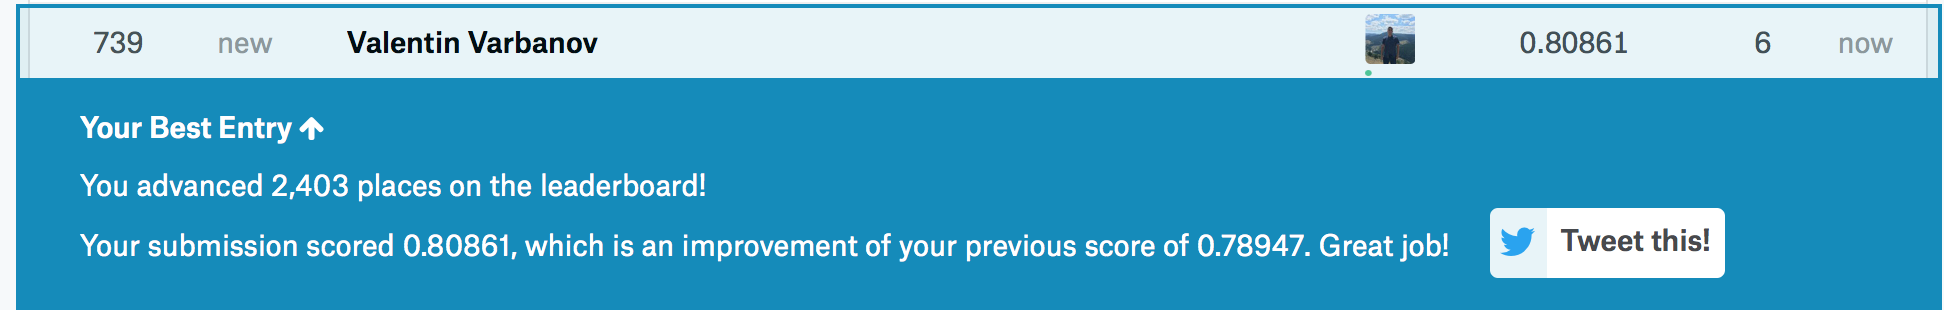